<a href="https://colab.research.google.com/github/SouvickG/COVID19_Twitter_Analysis/blob/main/COVID19NLPTwitterAnalysis_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!python -m pip install json-lines
#!pip install nltk==3.3
# CHANGE VARIABLE NAMES -> MODEL NAEMS

In [ ]:
from google.colab import files
import pandas as pd
file = files.upload()
df = pd.read_csv("textonly_for_annotation_2500.csv")
df["Emotions"] = df["Emotions"].str.lower()
labels = df["Emotions"]
df.head(10)

Saving textonly_for_annotation_2500.csv to textonly_for_annotation_2500.csv


,Unnamed: 0,file_id,id,id_str,full_text,Emotions,Confidence
0,1,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @cnnbrk: A man who lives in Snohomish Count...,neutral,h
1,2,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @ABC: BREAKING: First confirmed case of the...,neutral,h
2,3,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @zhang_qiii: CDC is to hold a Telebriefing ...,neutral,h
3,4,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @darhar981: First coronavirus case confirme...,neutral,h
4,5,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @CDCgov: The first human infection with new...,neutral,h
5,6,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,CDC Confirms First U.S. Case of Deadly China V...,neutral,h
6,7,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @CDCgov: The first human infection with new...,neutral,h
7,8,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @cnnbrk: A man who lives in Snohomish Count...,neutral,h
8,9,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,CDC confirms 1st case of #Coronoavirus in the ...,neutral,h
9,10,sample-covid-data-08.jsonl,1.220000e+18,1.220000e+18,RT @AnnCoulter: Oh for pete's sake! The Supre...,anger,m


In [ ]:
# Tokenizing inputs and saving it in tokenizedInputs
import nltk
from nltk.tokenize import TweetTokenizer
inputs = df["full_text"]
tknzr = TweetTokenizer()
tokenizedInputs = []
for i in range(len(inputs)):
  tokenizedInputs.append(tknzr.tokenize(inputs[i]))

In [ ]:
#Lemmatizer function and cleaning (hyperlinks, twitter handles, punctuation and special characters, stopwords)
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
def remove_noise_and_lemmatize(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#lemmatizing and cleaning tokenizedInputs and saving in cleanedInputs
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
cleanedWordInputs = []
for i in range(len(tokenizedInputs)):
  cleanedWordInputs.append(remove_noise_and_lemmatize(tokenizedInputs[i], stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#converts cleanedWordInputs + labels to finalDict  (cleanedWordInput, label)
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)
tokens_for_model = get_tweets_for_model(cleanedWordInputs)
import numpy as np
counter = 0
finalDict = [[] for elements in cleanedWordInputs]
for tweet_dict in tokens_for_model:
  temp = []
  temp.append(tweet_dict)
  temp.append(labels[counter])
  finalDict[counter] = temp
  counter += 1

In [ ]:
#splits up finalDict
dictionary_train_data = finalDict[:int(len(finalDict) * 0.8)]
dictionary_test_data = finalDict[int(len(finalDict) * 0.8) :]

In [ ]:
from nltk import classify
from nltk import DecisionTreeClassifier
decisionTreeClassifier = DecisionTreeClassifier.train(dictionary_train_data, 10000)
classify.accuracy(decisionTreeClassifier, dictionary_train_data)
#classify.accuracy(classifier, test_data)

0.7595

In [ ]:
from nltk import ConditionalExponentialClassifier
#classifierCEC = ConditionalExponentialClassifier.train(train_data)
#classify.accuracy(classifierCEC, train_data)
#classify.accuracy(classifierCEC, test_data)

In [ ]:
from nltk import MaxentClassifier
#classifierMaxent = MaxentClassifier.train(train_data)
#classify.accuracy(classifierMaxent, train_data)
#classify.accuracy(classifierMaxent, test_data)

In [ ]:
#saves dictionaryInputs as finalDict w/o the class
dictionaryInputs = []
for elements in finalDict:
  dictionaryInputs.append(elements[0])

In [ ]:
dictionaryInputs[0]

{'case': True,
 'confirm': True,
 'coronavirus': True,
 'county': True,
 'first': True,
 'live': True,
 'man': True,
 'rt': True,
 'snohomish': True,
 'us': True,
 'washington': True,
 'wuhan': True,
 '…': True}

In [ ]:
#creating bag of words input
import heapq
wordfreq = {}
for tokens in dictionaryInputs:
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
most_freq = heapq.nlargest(100000 , wordfreq, key=wordfreq.get)

In [ ]:
#creating bag of words input
sentence_vectors = []
for sentence_tokens in finalDict:
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

In [ ]:
sentence_vectors = np.asarray(sentence_vectors)
sentence_vectors.shape

(2500, 3694)

In [ ]:
#one hot encoding labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(labels)
oneHotEncodedOutputs = lb.transform(labels)

In [ ]:
split = int(0.8*len(sentence_vectors))
X_train, X_test, y_train, y_test = sentence_vectors[:split], sentence_vectors[split:], oneHotEncodedOutputs[:split], oneHotEncodedOutputs[split:]
X_train = np.expand_dims(X_train, axis=2)  
X_test = np.expand_dims(X_test, axis=2) 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(2000, 3694, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(20, return_sequences = True))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(9, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
            batch_size= 32,
            epochs=10,
            validation_split = 0.2,
              shuffle=True)

Epoch 1/10
50/50 [==============================] - 7s 130ms/step - loss: 1.1362 - accuracy: 0.6956 - val_loss: 0.6502 - val_accuracy: 0.8000
Epoch 2/10
50/50 [==============================] - 6s 115ms/step - loss: 0.8632 - accuracy: 0.7763 - val_loss: 0.4840 - val_accuracy: 0.8625
Epoch 3/10
50/50 [==============================] - 6s 118ms/step - loss: 0.7211 - accuracy: 0.8119 - val_loss: 0.4437 - val_accuracy: 0.8625
Epoch 4/10
50/50 [==============================] - 6s 117ms/step - loss: 0.7447 - accuracy: 0.8138 - val_loss: 0.4700 - val_accuracy: 0.8625
Epoch 5/10
50/50 [==============================] - 6s 118ms/step - loss: 0.7020 - accuracy: 0.8150 - val_loss: 0.4289 - val_accuracy: 0.8675
Epoch 6/10
50/50 [==============================] - 6s 115ms/step - loss: 0.6838 - accuracy: 0.8181 - val_loss: 0.4193 - val_accuracy: 0.8675
Epoch 7/10
50/50 [==============================] - 6s 116ms/step - loss: 1.5243 - accuracy: 0.8175 - val_loss: 0.7074 - val_accuracy: 0.8625
Epoch 

In [ ]:
check = model.predict(X_test)

In [ ]:
correct = 0
total = 0
for i in range(len(X_test)):
    act_label = np.argmax(y_test[i]) # act_label = 1 (index)
    pred_label = np.argmax(check[i]) # pred_label = 1 (index)
    if(act_label == pred_label):
        correct += 1
    total += 1
accuracy = (correct/total)

In [ ]:
accuracy

0.88

In [ ]:
#beginning to create word embeddings
#!pip install gensim

In [ ]:
from gensim.models import Word2Vec
#I used vector_size = 100, or default
model = Word2Vec(sentences=cleanedWordInputs, size = 300, min_count = 1)
words = list(model.wv.vocab)
len(words)

3694

In [ ]:
#print(model['word'])
#model = Word2Vec.load('model.bin')
model.wv.save_word2vec_format('embeddings.txt')

In [ ]:
	X = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
X

array([[ 0.3592929 ,  0.2349953 , -0.09606376, ...,  0.15629707,
        -0.16722423,  0.38143948],
       [ 0.1724488 ,  0.11281506, -0.07106724, ...,  0.08637039,
        -0.06769145,  0.15599902],
       [ 0.1699767 ,  0.11520747, -0.06459989, ...,  0.08468382,
        -0.07056413,  0.1563458 ],
       ...,
       [ 0.00624518,  0.00229504, -0.00349925, ...,  0.00423603,
        -0.00142099,  0.00671736],
       [ 0.00741278,  0.0036946 , -0.00212729, ...,  0.00422847,
        -0.00238785,  0.00464786],
       [ 0.00657503,  0.0043926 , -0.00144292, ...,  0.00403216,
        -0.00260594,  0.00590094]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127464 missing from current font.
  fon

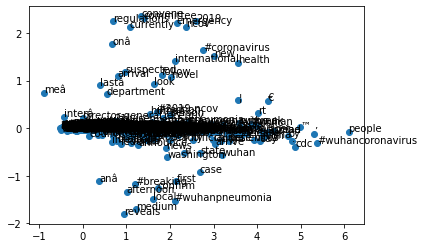

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
X.shape

(3694, 300)

In [ ]:
similar_words = model.most_similar('virus')	
print(similar_words)

[('late', 0.9999065399169922), ('control', 0.9998847246170044), ('—', 0.9998525381088257), ('say', 0.9998519420623779), ('kill', 0.9998487234115601), ('1', 0.9998388290405273), ('#wuhancoronavirus', 0.9998356103897095), ('c', 0.9998253583908081), ('6', 0.9997936487197876), ('china', 0.9997925162315369)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
similarity_two_words = model.similarity('please','see')
print("Please provide the similarity between these two words:")
print(similarity_two_words)

Please provide the similarity between these two words:
0.9998069


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
X.shape

(3694, 300)

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
     

class TextToTensor():

    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def string_to_tensor(self, string_list: list) -> list:
        """
        A method to convert a string list to a tensor for a deep learning model
        """    
        string_list = self.tokenizer.texts_to_sequences(string_list)
        string_list = pad_sequences(string_list, maxlen=self.max_len)
        
        return string_list

In [ ]:
# Tokenizing the text
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleanedWordInputs)
# Getting the longest sentence
max_len = np.max([len(text) for text in cleanedWordInputs])
# Converting to tensor
TextToTensor_instance = TextToTensor(
tokenizer=tokenizer,
max_len=max_len
)
cleanedBOWInputs = TextToTensor_instance.string_to_tensor(cleanedWordInputs)

In [ ]:
cleanedBOWInputs[5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   7, 128,   5,  22,   4,
        63,  17,  23,  49], dtype=int32)

In [ ]:
import numpy as np


class Embeddings():
    """
    A class to read the word embedding file and to create the word embedding matrix
    """

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr)

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [ ]:
from keras.layers import Embedding
#used to be 100 instead of 300
embedding_dims = 300
embeddingCheck = Embeddings('embeddings.txt', 300)
embedding_matrix = embeddingCheck.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [ ]:
split = int(0.8*len(cleanedBOWInputs))
X_train, X_test, y_train, y_test = cleanedBOWInputs[:split], cleanedBOWInputs[split:], oneHotEncodedOutputs[:split], oneHotEncodedOutputs[split:]

In [ ]:
from keras.layers import Bidirectional
import tensorflow as tf
from keras import regularizers
from keras.layers import Conv2D
import keras

model = Sequential()
model.add(Embedding(
  input_dim= (X.shape[0] + 1), 
  output_dim=embedding_dims, 
  input_length=max_len,
  weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(30, return_sequences= True, recurrent_dropout = .1)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(9, activation = 'softmax'))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.optimizers import Adam
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split= .2, callbacks= callback, shuffle = True)

Epoch 1/10
50/50 [==============================] - 9s 186ms/step - loss: 0.8267 - accuracy: 0.7350 - val_loss: 0.4251 - val_accuracy: 0.8150
Epoch 2/10
50/50 [==============================] - 9s 178ms/step - loss: 0.5116 - accuracy: 0.8450 - val_loss: 0.4007 - val_accuracy: 0.8575
Epoch 3/10
50/50 [==============================] - 9s 171ms/step - loss: 0.3297 - accuracy: 0.9006 - val_loss: 0.4399 - val_accuracy: 0.8475
Epoch 4/10
50/50 [==============================] - 9s 176ms/step - loss: 0.2218 - accuracy: 0.9319 - val_loss: 0.6852 - val_accuracy: 0.7950
Epoch 5/10
50/50 [==============================] - 9s 170ms/step - loss: 0.1735 - accuracy: 0.9488 - val_loss: 0.4365 - val_accuracy: 0.8800


In [ ]:
check = model.predict(X_test)
correct = 0
total = 0
for i in range(len(X_test)):
    act_label = np.argmax(y_test[i]) # act_label = 1 (index)
    pred_label = np.argmax(check[i]) # pred_label = 1 (index)
    if(act_label == pred_label):
        correct += 1
    total += 1
accuracy = (correct/total)

In [ ]:
accuracy

0.77